In [101]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [102]:
# Define colors
color_right = [0, 255, 0]
color_wrong = [255, 0, 0]
color_waiting_wrong = [255, 128, 0]
color_waiting = [255, 255, 0]
color_neutral = [0, 0, 255]

In [103]:
# Attribute the colors to the statuses
color_statuses = {'right':color_right,
                  'wrong':color_wrong,
                  'waiting_wrong':color_waiting_wrong,
                  'waiting':color_waiting,
                  'neutral':color_neutral}

In [104]:
# Define base_notes_names
base_notes_names =['Mi4', 'Fa4', 'Sol4', 'La4', 'Si4', 'Do5', 'Ré5', 'Mi5', 'Fa5']
base_notes_names.reverse()

In [105]:
def get_lines(img):
    # The goal is to find the lines of the music sheet
    # Return lines that stores in order the heights of the lines
    
    # Convert to grayscale
    gray = np.float32(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    
    # Find the lines of the image using the HoughLinesP function
    rho_resolution = 1
    theta_resolution = np.pi / 180
    threshold = 155
    hough_lines = cv2.HoughLinesP(image = (255 - gray).astype(np.uint8),
                                  rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                                  minLineLength = 100, maxLineGap = 10)

    # Keep only one line for each line of the music sheet
    # Get all lines in a consecutive order
    all_lines = []
    for i in range(len(hough_lines)):
        line = hough_lines[i]
        for a,b,c,d in line:
            all_lines.append(b)
    all_lines.sort()
    # Group the lines that are consecutive
    all_lines_separated = np.split(all_lines, np.where(np.diff(all_lines) != 1)[0]+1)
    # Keep the rounded median for each group
    lines = [int(np.median(group)) for group in all_lines_separated]
    
    return lines

In [106]:
def get_interline(lines):
    # Compute the average interline
    interline = round(np.mean([lines[i + 1] - lines[i] for i in range(len(lines) - 1)]))
    return interline

In [107]:
def get_base_notes_coordinates(lines):
    # Take the lines and the middles
    base_notes_coordinates = lines.copy()
    for i in range(1, len(lines)):
        base_notes_coordinates.append(int((lines[i] + lines[i - 1]) / 2))
    base_notes_coordinates.sort()
    return base_notes_coordinates

In [108]:
def get_dic(base_notes_coordinates):
    # Associate the name according to the coordinates
    dic_int_to_note = {}
    for i in range(len(base_notes_names)):
        dic_int_to_note[base_notes_coordinates[i]] = base_notes_names[i]
    return dic_int_to_note

In [109]:
def get_notes_coordinates(img, interline):
    # The goal is to find the notes coordinates on the music sheet
    # Return notes that stores in chronological order the centers of the notes

    # Convert to grayscale and pply the sobel filter
    gray = np.float32(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255
    
    # Find the circles of the image using the HoughCircles function
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 20, param1 = 2, param2 = 10,
                               minRadius = int(interline / 2 * 0.8), maxRadius = int(interline / 2 * 1.2))
    circles = np.uint16(np.around(circles))

    # Keep only the notes (black center)
    notes_coordinates = []
    for i in circles[0,:]:
        # only keep the notes (black center):
        if img[i[1], i[0], 0] < 100:
            notes_coordinates.append(i[:-1])
    notes_coordinates = sorted(notes_coordinates, key = lambda x : x[0])
    
    return notes_coordinates

In [110]:
def get_notes_names(notes_coordinates, base_notes_coordinates, dic_int_to_note):
    # Attribute the closest note to each
    
    def closest_note(note):
        return base_notes_coordinates[np.array(abs(base_notes_coordinates - note[1])).argmin()]

    notes_names = []
    for note in notes_coordinates:
        notes_names.append(dic_int_to_note.get(closest_note(note)))
    
    return(notes_names)

In [111]:
class sheet:

    def __init__(self, img):
        self.img = cv2.imread(img)
        self.current_note = 0
        self.lines = get_lines(self.img)
        self.interline = get_interline(self.lines)
        self.base_notes_coordinates = get_base_notes_coordinates(self.lines)
        self.dic_int_to_note = get_dic(self.base_notes_coordinates)
        self.notes_coordinates = get_notes_coordinates(self.img, self.interline)
        self.notes_names = get_notes_names(self.notes_coordinates, self.base_notes_coordinates, self.dic_int_to_note)
        self.nb_notes = len(self.notes_coordinates)
        self.notes_status = ['neutral' for i in range(self.nb_notes)]
        self.notes_status[0] = 'waiting'

    def show_sheet(self):
        plt.figure(figsize=(16,6))
        plt.imshow(self.img)
        plt.show()
     
    def draw_lines(self, b_show=True):
        color_line = color_neutral
        thickness = 1
        for line in self.lines:
            cv2.line(self.img, (0, line), (self.img.shape[1], line), color_line, thickness)
        if b_show:
            self.show_sheet()
    
    def draw_notes_names(self, b_show=True):
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color_name = color_neutral
        thickness = 2
        for i in range(self.nb_notes):
            self.img = cv2.putText(self.img, self.notes_names[i], (self.notes_coordinates[i][0], 30),
                                   font, fontScale, color_name, thickness, cv2.LINE_AA)
        if b_show:
            self.show_sheet()
    
    def draw_note(self, i, b_show=False):
        color_note = color_statuses.get(self.notes_status[i])
        color_note_center = color_neutral
        note_radius = int(self.interline / 2)
        # draw the outer circle
        cv2.circle(self.img, (self.notes_coordinates[i][0], self.notes_coordinates[i][1]), note_radius, color_note, 2)
        # draw the center of the circle
        cv2.circle(self.img, (self.notes_coordinates[i][0], self.notes_coordinates[i][1]), 2, color_note_center, 3)
        if b_show:
            self.show_sheet()
        
    def draw_notes(self, b_show=True):
        for i in range(self.nb_notes):
            self.draw_note(i)
        if b_show:
            self.show_sheet()
    
    def compute_note(self, note, b_draw_show=True):
        if self.current_note < self.nb_notes:
            if note == self.notes_names[self.current_note]:
                if self.notes_status[self.current_note] == 'waiting':
                    self.notes_status[self.current_note] = 'right'
                else:
                    self.notes_status[self.current_note] = 'wrong'
                self.current_note += 1
                if self.current_note < self.nb_notes:
                    self.notes_status[self.current_note] = 'waiting'
            else:
                if self.notes_status[self.current_note] == 'waiting':
                    self.notes_status[self.current_note] = 'waiting_wrong'
        if b_draw_show:
            my_sheet.draw_notes()
    
    def compute_notes(self, notes, b_progressive=False, b_draw_show=True):
        if b_progressive:
            for note in notes:
                self.compute_note(note, b_draw_show)
        else:
            for note in notes:
                self.compute_note(note, False)
            my_sheet.draw_notes(b_draw_show)

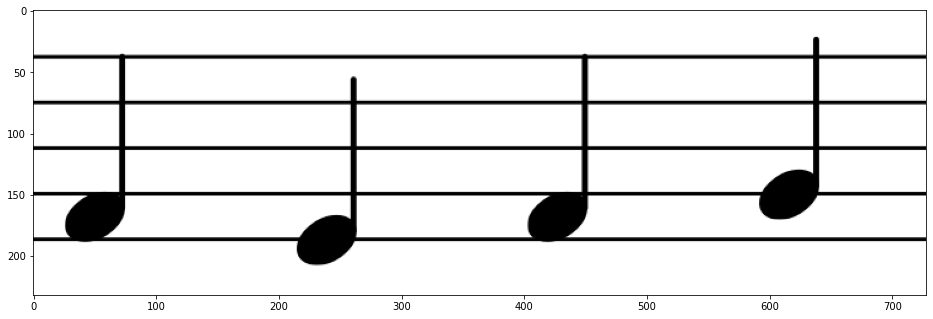

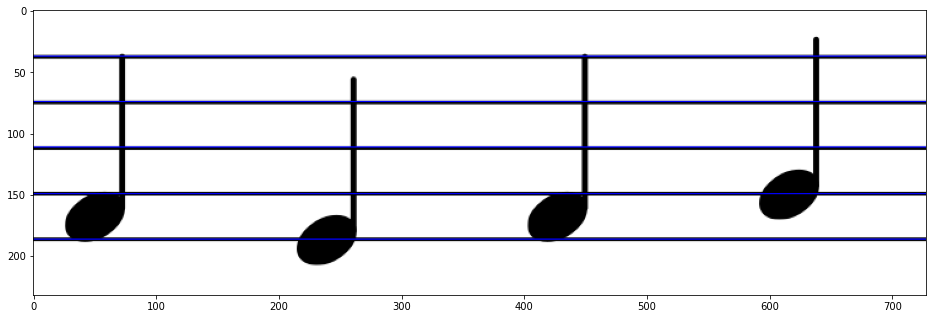

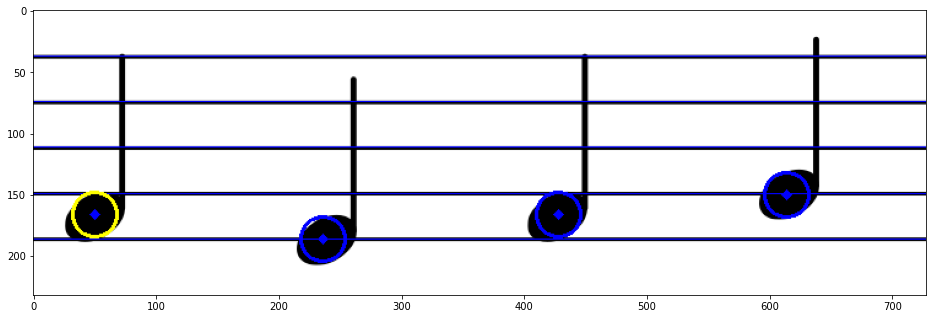

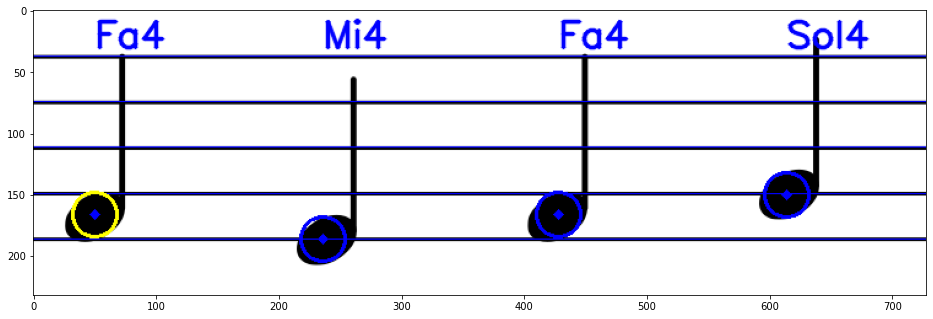

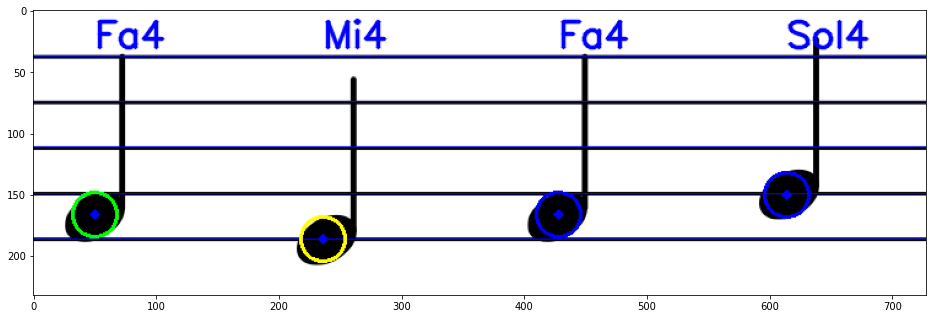

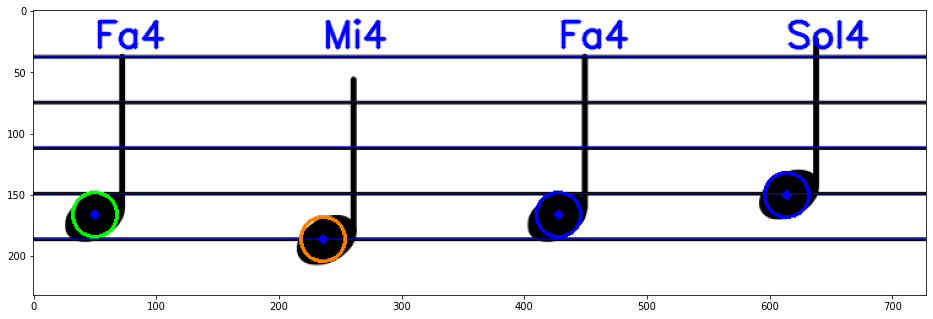

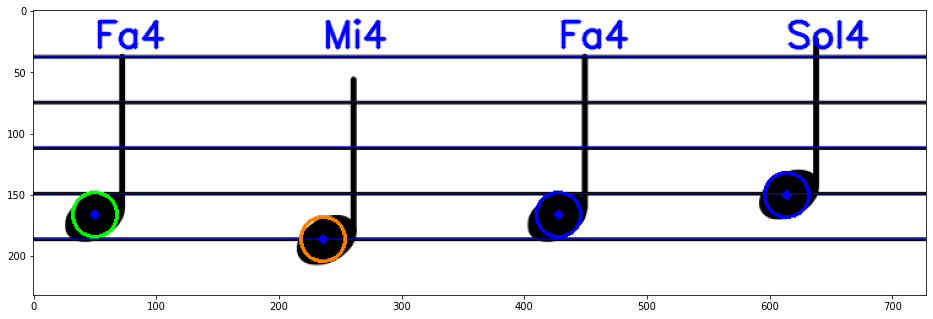

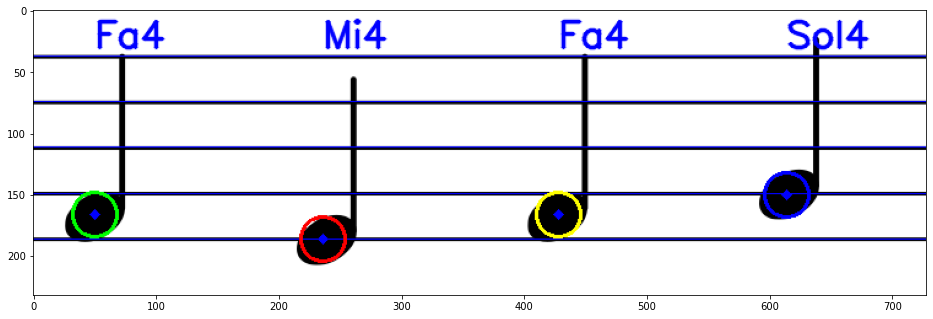

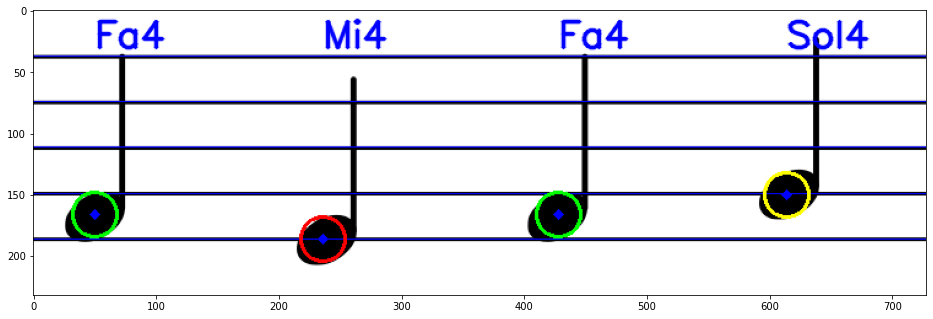

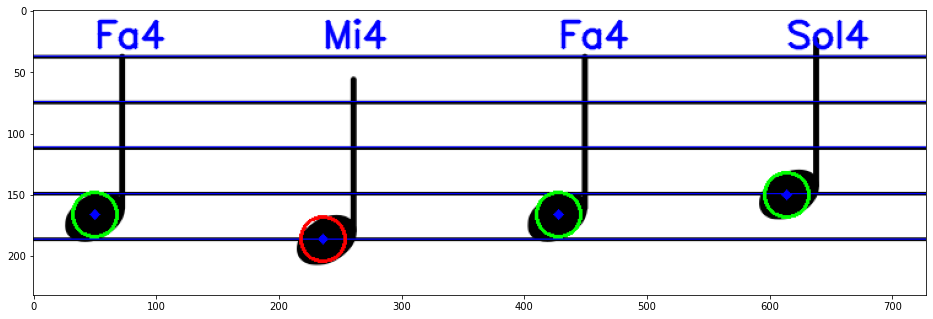

In [112]:
# testing
my_sheet = sheet('pictures/simplesheet.png')
my_sheet.show_sheet()
my_sheet.draw_lines()
my_sheet.draw_notes()
my_sheet.draw_notes_names()
my_sheet.compute_notes(['Fa4','Sol4','Fa4','Mi4','Fa4', 'Sol4'], True, True)

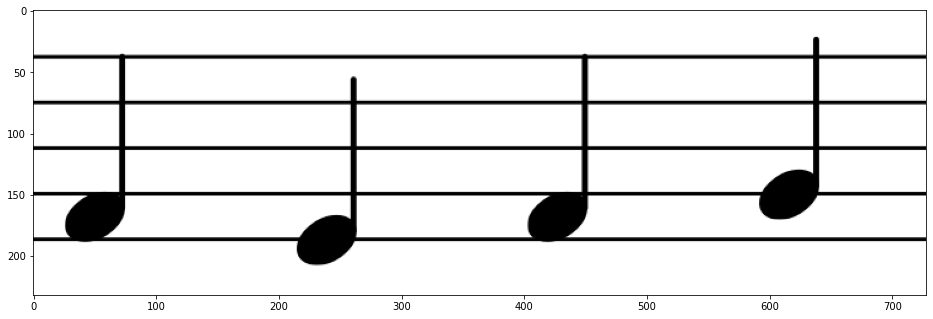

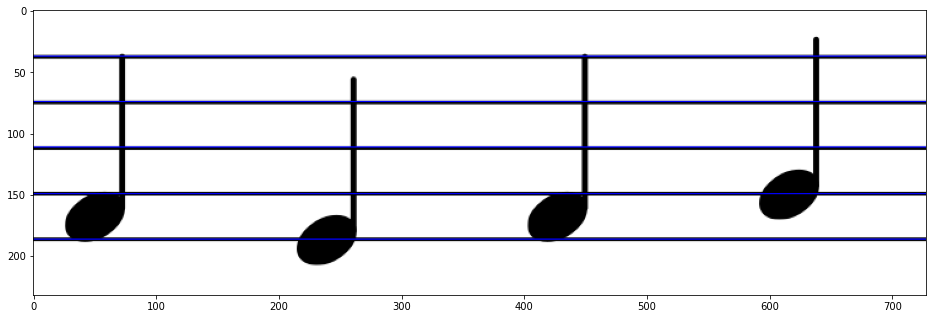

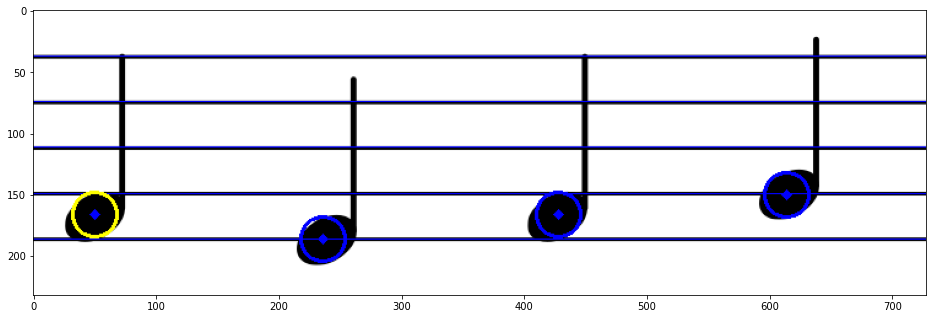

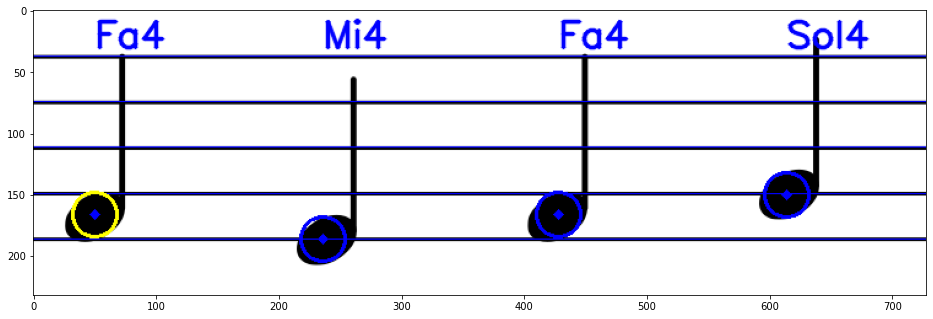

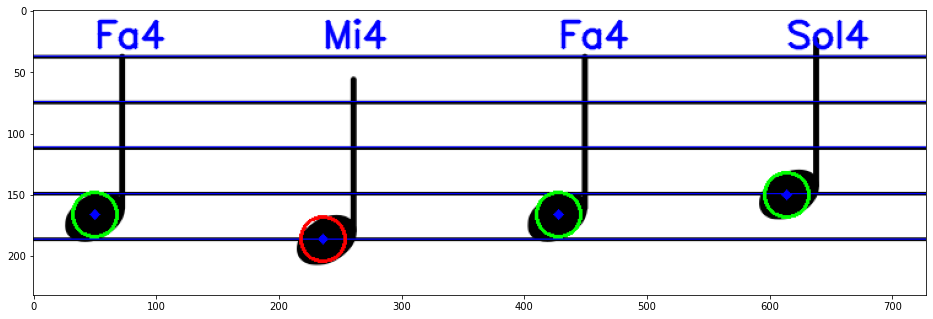

In [113]:
# testing
my_sheet = sheet('pictures/simplesheet.png')
my_sheet.show_sheet()
my_sheet.draw_lines()
my_sheet.draw_notes()
my_sheet.draw_notes_names()
my_sheet.compute_notes(['Fa4','Sol4','Fa4','Mi4','Fa4', 'Sol4'], False, True)

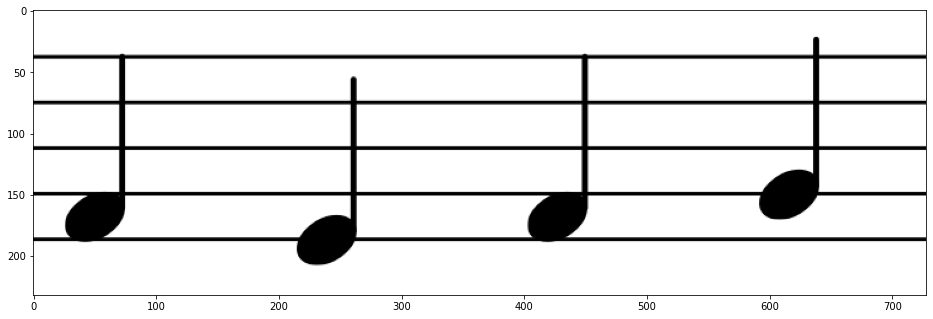

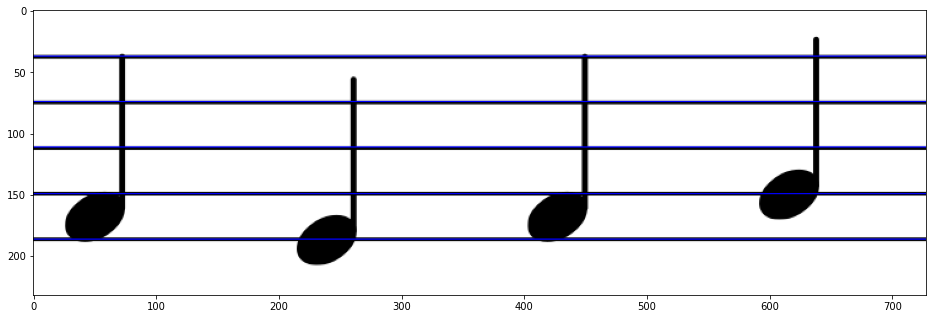

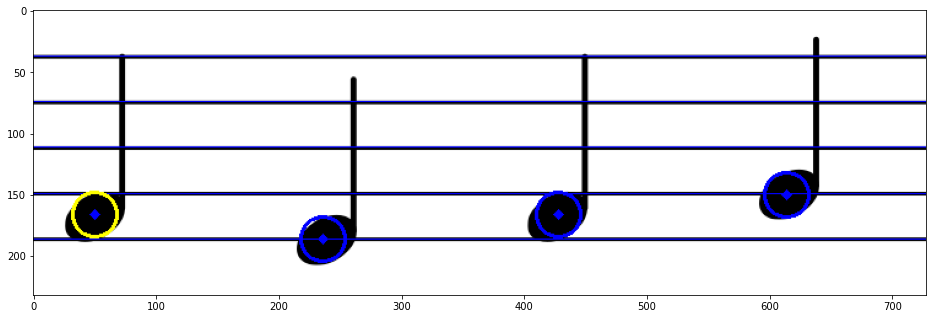

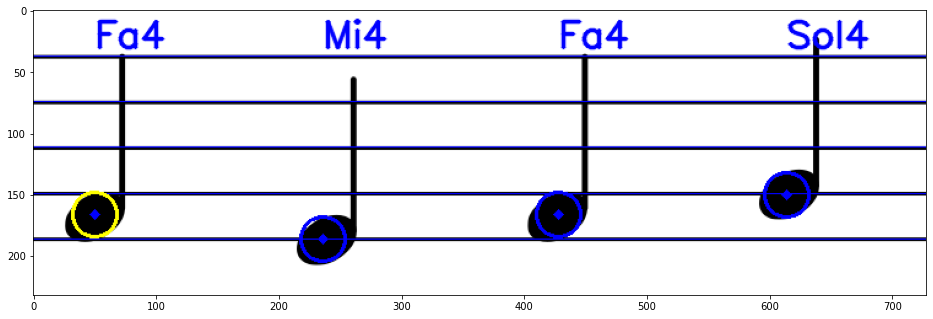

In [114]:
# testing
my_sheet = sheet('pictures/simplesheet.png')
my_sheet.show_sheet()
my_sheet.draw_lines()
my_sheet.draw_notes()
my_sheet.draw_notes_names()
my_sheet.compute_notes(['Fa4','Sol4','Fa4','Mi4','Fa4', 'Sol4'], False, False)

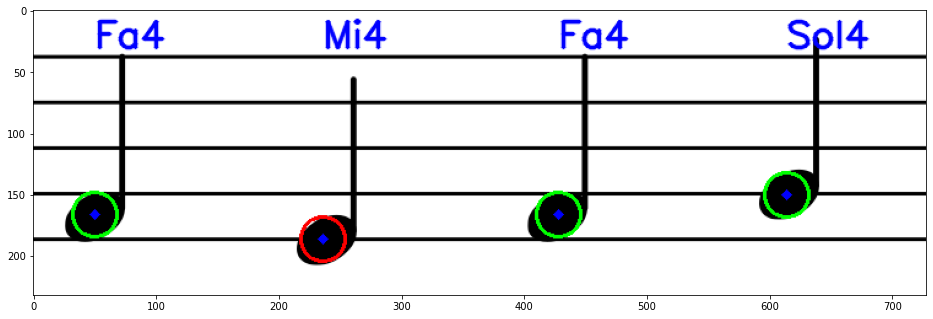

In [115]:
# testing
my_sheet = sheet('pictures/simplesheet.png')
my_sheet.draw_notes_names(False)
my_sheet.compute_notes(['Fa4','Sol4','Fa4','Mi4','Fa4', 'Sol4'])

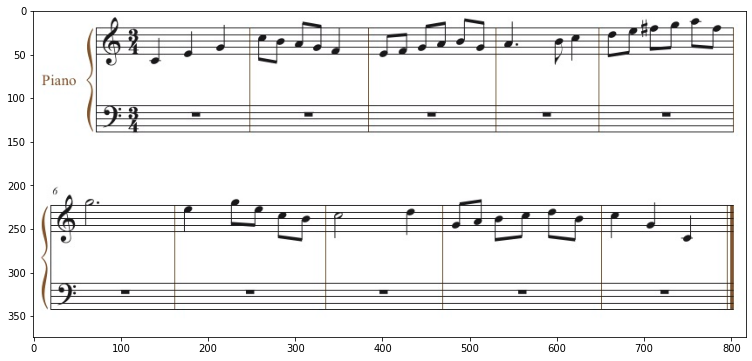

In [116]:
img = cv2.imread('pictures/simplesheetpiano.png')
plt.figure(figsize=(16,6))
plt.imshow(img)
plt.show()

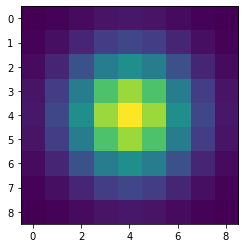

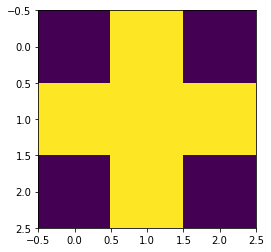

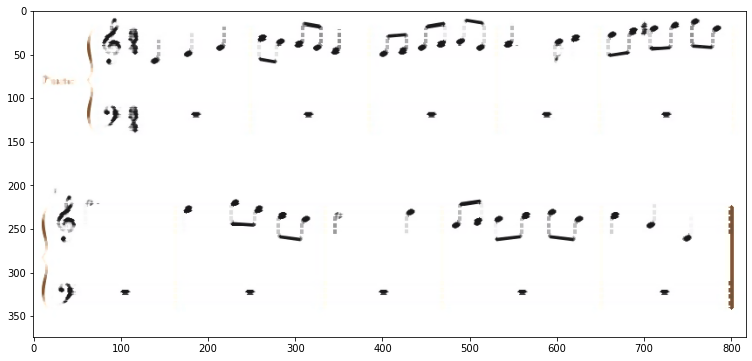

In [117]:
# the partition has notes, and we wont to find the notes by convoluting with a circle kernel

# gaussian kernel
kernel_size = 9
kernel = cv2.getGaussianKernel(kernel_size, 0)
kernel = kernel * kernel.T
plt.figure(figsize=(4,4))
plt.imshow(kernel)
plt.show()

kernel_size = 3
kernel = np.zeros((kernel_size, kernel_size))
cv2.circle(kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 1, -1)
plt.figure(figsize=(4,4))
plt.imshow(kernel)
plt.show()

img_conv = cv2.medianBlur(img,5)
plt.figure(figsize=(16,6))
plt.imshow(img_conv)
plt.show()

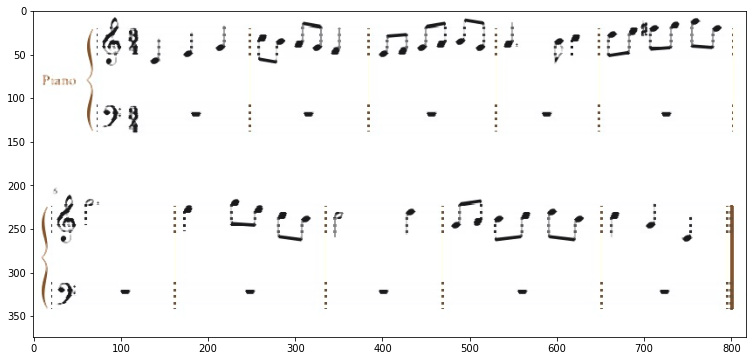

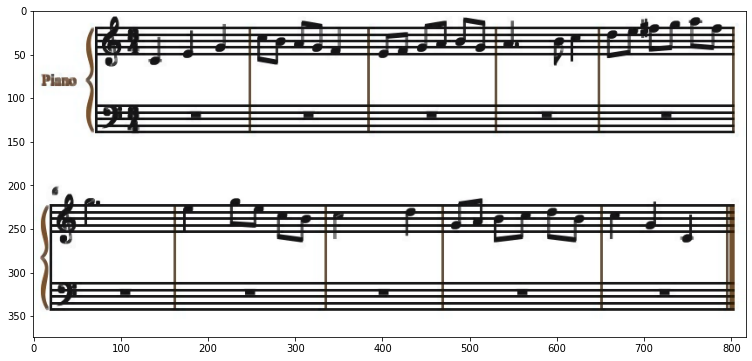

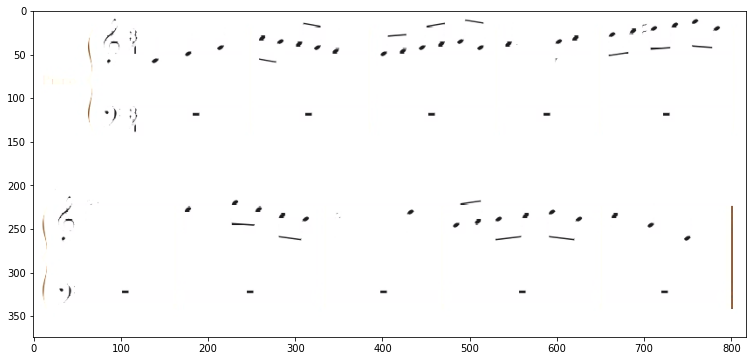

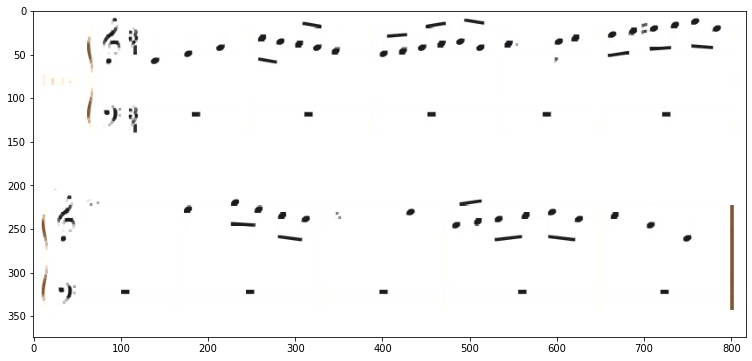

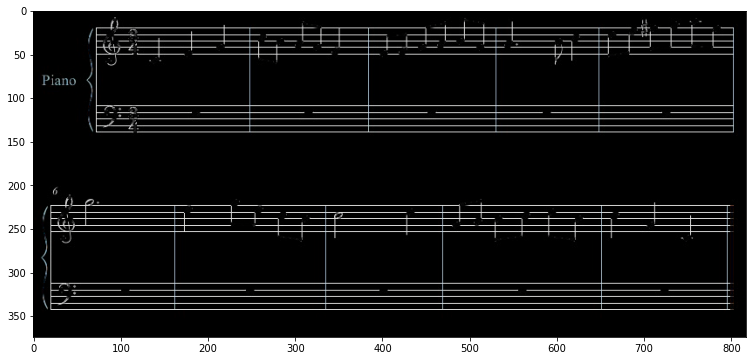

In [118]:
img_conv = cv2.medianBlur(img,3)
plt.figure(figsize=(16,6))
plt.imshow(img_conv)
plt.show()

# using cv2 erosion
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
plt.figure(figsize=(16,6))
plt.imshow(erosion)
plt.show()

# using cv2 dilation
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilation = cv2.dilate(img,kernel,iterations = 1)
plt.figure(figsize=(16,6))
plt.imshow(dilation)
plt.show()

erosion = cv2.erode(dilation,kernel,iterations = 1)
plt.figure(figsize=(16,6))
plt.imshow(erosion)
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(erosion-img)
plt.show()


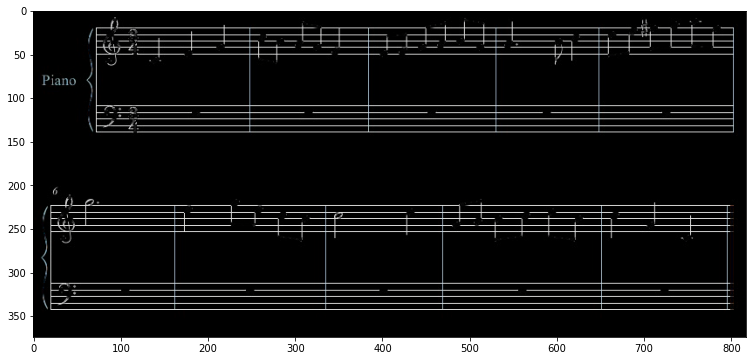

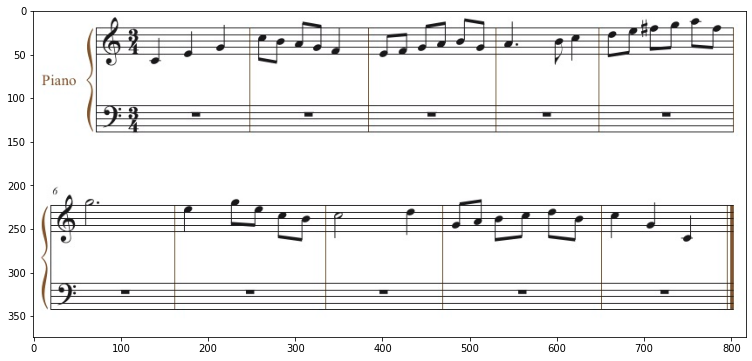

In [126]:
img = cv2.imread('pictures/simplesheetpiano.png')
plt.figure(figsize=(16,6))
plt.imshow(img)
plt.show()

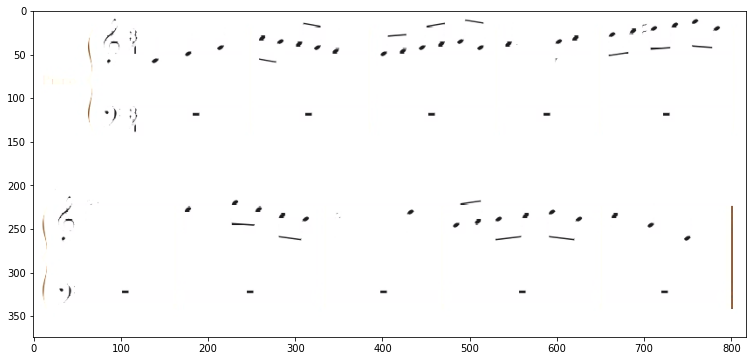

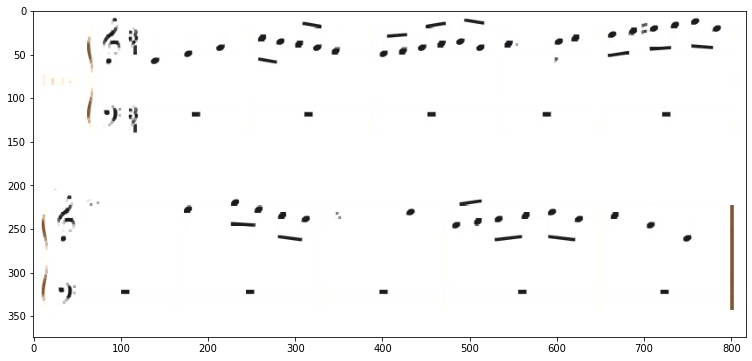

In [155]:
def dilate_erode(img, kernel_size=3, iterations=1, show = False):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    erosion = cv2.erode(dilation,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.show()
    return erosion

img_eroded = dilate_erode(img, 3, show = True)

In [156]:
def get_notes_coordinates(img, interline):
    # The goal is to find the notes coordinates on the music sheet
    # Return notes that stores in chronological order the centers of the notes

    # Convert to grayscale and pply the sobel filter
    gray = np.float32(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255
    
    # Find the circles of the image using the HoughCircles function
    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 20, param1 = 2, param2 = 10,
                               minRadius = int(interline / 2 * 0.8), maxRadius = int(interline / 2 * 1.2))
    circles = np.uint16(np.around(circles))

    # Keep only the notes (black center)
    notes_coordinates = []
    for i in circles[0,:]:
        # only keep the notes (black center):
        if img[i[1], i[0], 0] < 100:
            notes_coordinates.append(i[:-1])
    notes_coordinates = sorted(notes_coordinates, key = lambda x : x[0])
    
    return notes_coordinates

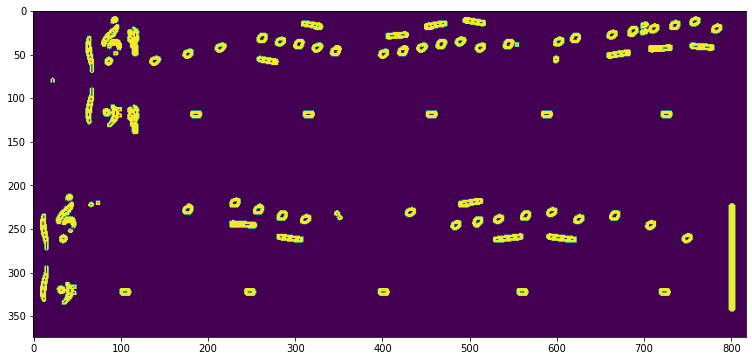

In [231]:
# Convert to grayscale and pply the sobel filter
gray = np.float32(cv2.cvtColor(img_eroded,cv2.COLOR_BGR2GRAY))
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = (sobel / sobel.max()*255).astype(np.uint8)
black_white_threshold = 30
sobel[sobel <= black_white_threshold] = 0
sobel[sobel > black_white_threshold] = 255


plt.figure(figsize=(16,6))
plt.imshow(sobel)
plt.show()

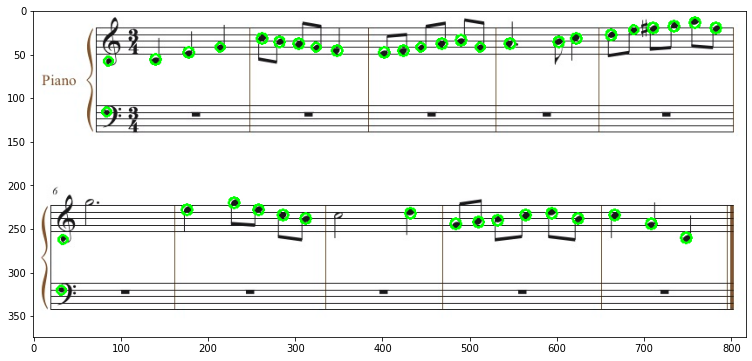

In [188]:
# Find the circles of the image using the HoughCircles function
circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 10, param1 = 1, param2 = 8,
                            minRadius = 5,
                            maxRadius = 7
                        )
circles = np.uint16(np.around(circles))

# draw the circles
img_circles = img.copy()
for i in circles[0,:]:
    cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

plt.figure(figsize=(16,6))
plt.imshow(img_circles)
plt.show()


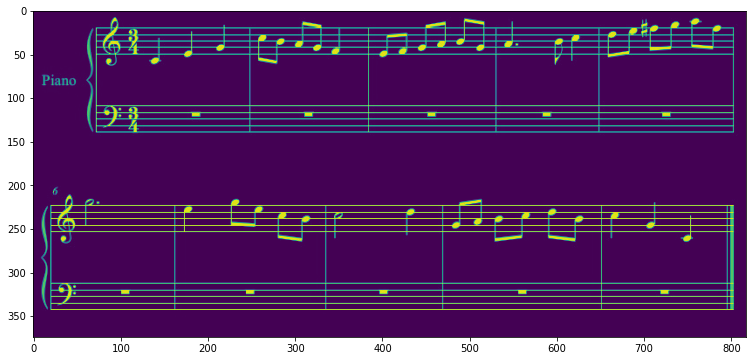

In [192]:
# find les blanches

gray = np.float32(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
inverse = gray.max() - gray
inverse = (inverse / inverse.max()*255).astype(np.uint8)

plt.figure(figsize=(16,6))
plt.imshow(inverse)
plt.show()


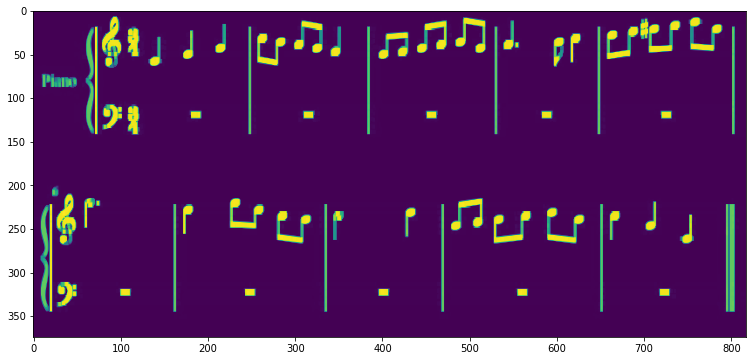

In [228]:
# erosion along the y axis
kernel_size = 2
kernel = np.ones((kernel_size,1), np.uint8)
erosion = cv2.erode(inverse,kernel,iterations = 1)
#plt.figure(figsize=(16,6))
#plt.imshow(erosion)
#plt.show()

# dilation along the y axis
kernel_size = 3
kernel = np.ones((kernel_size+2,kernel_size), np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 1)
plt.figure(figsize=(16,6))
plt.imshow(dilation)
plt.show()

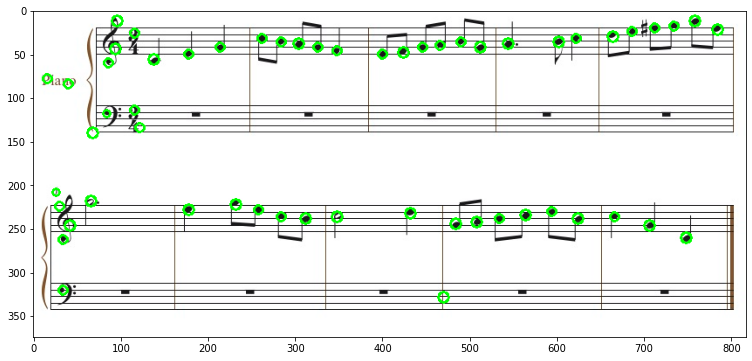

In [229]:
# Find the circles of the image using the HoughCircles function
circles = cv2.HoughCircles(dilation, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 8,
                            minRadius = 4,
                            maxRadius = 7
                        )
circles = np.uint16(np.around(circles))

# draw the circles
img_circles = img.copy()
for i in circles[0,:]:
    cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

plt.figure(figsize=(16,6))
plt.imshow(img_circles)
plt.show()


In [ ]:
# Find the circles of the image using the HoughCircles function
circles = cv2.HoughCircles(inverse, cv2.HOUGH_GRADIENT, dp = 1, minDist = 10, param1 = 1, param2 = 8,
                            minRadius = 5,
                            maxRadius = 7
                        )
circles = np.uint16(np.around(circles))

# draw the circles
img_circles = img.copy()
for i in circles[0,:]:
    cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

plt.figure(figsize=(16,6))
plt.imshow(img_circles)
plt.show()

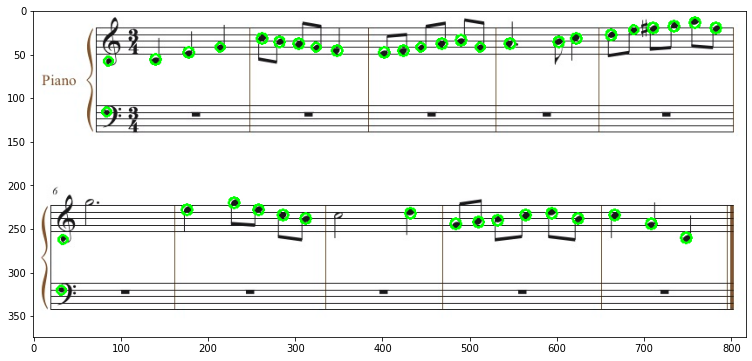

In [230]:
def get_black_notes(img):

    gray = np.float32(cv2.cvtColor(img_eroded,cv2.COLOR_BGR2GRAY))
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)
    black_white_threshold = 30
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 10, param1 = 1, param2 = 8,
                                minRadius = 5,
                                maxRadius = 7
                            )
    circles = np.uint16(np.around(circles))

    img_circles = img.copy()
    for i in circles[0,:]:
        cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

    plt.figure(figsize=(16,6))
    plt.imshow(img_circles)
    plt.show()

img = cv2.imread('pictures/simplesheetpiano.png')
get_black_notes(img)
